# Connectivity - implementations

#### Loading data & basic algorithm

In [49]:
from artificial_data import *
from sklearn.metrics import adjusted_rand_score as AR
X, labels = importBiggerArtificialData()
# X, labels = importSmallerArtificialData()

from sklearn.neighbors import NearestNeighbors
from sklearn.neighbors import kneighbors_graph
import numpy as np
import networkx as nx
from sklearn.cluster import KMeans


def check_symmetric(a, tol=1e-8):
    return np.all(np.abs(a-a.T) < tol)


def adjacencyMatrixUsingMnearestNeighbors(X, M = 5):
    
    knn = NearestNeighbors(n_neighbors=M)
    knn.fit(X)
    dist_indx_arr = knn.kneighbors(X, return_distance=True, n_neighbors = M)
    
    A = kneighbors_graph(X, n_neighbors=(M-1), p=2, mode='connectivity', include_self=False) 
    A = A.toarray()# for some reason, is not symmetric
    A = np.maximum( A, A.T )
    
    return A, dist_indx_arr # dist_indx_arr will be useful while connecting the graph

def adjacencyMatrixUsingMnearestNeighbors2(X, M=5, M_search_thresh=7):
    
    assert M_search_thresh >= M
    
    knn = NearestNeighbors(n_neighbors=M)
    knn.fit(X)   
    dist_indx_arr = knn.kneighbors(X, return_distance=True, n_neighbors = M_search_thresh + 1)
    
    A = kneighbors_graph(X, n_neighbors=(M-1), p=2, mode='connectivity', include_self=False) 
    A = A.toarray()# for some reason, is not symmetric
    A = np.maximum( A, A.T )
    
    return A, dist_indx_arr # dist_indx_arr will be useful while connecting the graph

    
    
def connectTheGraph(A, dist_indx_arr=None):
    
    # to be implemented
        # trivial case of adding an edge:
    W = A
    G = nx.from_numpy_array(W)
    graphs = list(nx.connected_components(G))
    for i in range(len(graphs)-1):

        for g in graphs[i]:
            for f in graphs[i+1]:
                W[f,g] = 1
                W[g,f] = 1
                break
            break
#     print(nx.number_connected_components(nx.from_numpy_array(W)))
    
    return W

def graphLaplacian(A):
    D = np.eye(A.shape[0]) * A.sum(axis=0) # diagonal matrix of degrees
    return D  - A # L = D - A
    



def calculateEigenVectorsOfGraphLaplacian(L):
    eigenValues, eigenVectors = np.linalg.eig(L)
    eigenValues, eigenVectors = eigenValues.real, eigenVectors.real
    
    idx = eigenValues.argsort()[::1]   
    eigenValues = eigenValues[idx]
    eigenVectors = eigenVectors[:,idx]
    
    return eigenValues,eigenVectors
    
    
    
def nodeRepresentation(eigenVectors, nodeRepresentationDim, n_of_components=1):
    m = n_of_components # we assume n of connected components = 1
    Z = eigenVectors[:,m:(nodeRepresentationDim + m)] # we omit m first eigenvectors, where m is the number of components of graph from A
    return Z
    
    

def spectralClustering(X, n_of_clusters=3, M=3, nodeRepresentationDim=3):
    
    A, d = adjacencyMatrixUsingMnearestNeighbors(X, M=M)
    A_connected = connectTheGraph(A, d)
    L = graphLaplacian(A_connected)
    w,v = calculateEigenVectorsOfGraphLaplacian(L)
    Z = nodeRepresentation(v,nodeRepresentationDim,n_of_components=1)
    

#     print(Z.shape)
    kmeans = KMeans(n_clusters=n_of_clusters, random_state=0, n_init=100).fit(Z)
    return kmeans.labels_


def spectralNR(X, n_of_clusters=3, M=3, nodeRepresentationDim=3):
    
    A, d = adjacencyMatrixUsingMnearestNeighbors(X, M=M)
    A_connected = connectTheGraph(A, d)
    L = graphLaplacian(A_connected)
    w,v = calculateEigenVectorsOfGraphLaplacian(L)
    Z = nodeRepresentation(v,nodeRepresentationDim,n_of_components=1)
    return Z
    
    
    

In [23]:
A,d = adjacencyMatrixUsingMnearestNeighbors(X, M=5, M_search_thresh=6)

#### Another way of connecting A - using distances

In [2]:

def FWTFfind(d, M, MST):
    distances = d[0][:, 1:]
    indexes = d[1][:, 1:]

    fw = list()
    tw = list()

    for m_idx in range(M, MST): # M+1 ?
        from_which = distances[:,m_idx].argsort()
        to_which = indexes[:, m_idx][from_which]

        fw.append(from_which)
        tw.append(to_which)
    return fw, tw



In [80]:
def defineEdgesToAdd(fw,tw, percentage):
    
    
    vertices = len(fw[0])
    
    n_of_edges = float(len(fw))* vertices
    n_of_edges_to_add = int(n_of_edges*percentage)
    
    edges_to_add = list()
    
    for xd in range(int(n_of_edges_to_add//vertices) ):
#         print(f'xd: {xd}')
        edges_to_add.append(vertices)
        
        n_of_edges_to_add = n_of_edges_to_add - vertices
    
    if n_of_edges_to_add != 0:
        edges_to_add.append(int(n_of_edges_to_add))
    
#     print(f'vertices: {vertices}')
#     print(f'n_of_edges_to_add: {n_of_edges_to_add}')
#     print(f'edges_to_add: {edges_to_add}')
    
    
    
    return edges_to_add




def connectTheGraph2(A, dist_indx_arr=None, fw=None,tw=None, edges_to_add=list()):
    
    W = A
    
#     print(f'Len fw = {len(fw)}')
#     print(f'Len edges_to_add = {len(edges_to_add)}')
    
    for i in range(len(edges_to_add)):
        for j in range(edges_to_add[i]):
            W[fw[i][j],tw[i][j]] = 1
            W[tw[i][j],fw[i][j]] = 1
    
    
    
    
    # trivial case of adding an edge:
    
    G = nx.from_numpy_array(W)
    graphs = list(nx.connected_components(G))
    
    if len(graphs) == 1:
#         print('W IS ALREADY CONNECTED!')
        return W
    
    # its still not connected - connect it trivially
    for i in range(len(graphs)-1):

        for g in graphs[i]:
            for f in graphs[i+1]:
                W[f,g] = 1
                W[g,f] = 1
                break
            break

    
    return W






In [65]:
percs = np.linspace(0.05,0.5, 10)
percs

array([0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ])

# Experiment for checking spectralClustering2 - for animation no 2

( modification focuses on adding given fraction/percentage of prioritized edges, where the priority is based on each node's distance)

In [60]:
def spectralClustering2Experiment(X, n_of_clusters=3, M=3, nodeRepresentationDim=3, MST=4):
    
    A, d = adjacencyMatrixUsingMnearestNeighbors2(X, M=M, M_search_thresh=MST)
    
    fw, tw = FWTFfind(d, M, MST)
    print(fw)
    print(tw)
    
    # for each percentage
    
    ars = list()
    zs = list()
    
#     percs = np.linspace(0.05,0.5, 10)
    
    for perc in percs:
        print(f'perc = {perc}')
        

        edges_to_add = defineEdgesToAdd(fw=fw,tw=tw, percentage=perc)

        A_connected = connectTheGraph2(A, dist_indx_arr=None, fw=fw,tw=tw, edges_to_add=edges_to_add)
        print(f'A.sum() = {A_connected.sum()}')
        print(f'A is symmetric: {check_symmetric(A_connected)}')

        L = graphLaplacian(A_connected)
        w,v = calculateEigenVectorsOfGraphLaplacian(L)
        Z = nodeRepresentation(v,nodeRepresentationDim,n_of_components=1)
        zs.append(Z)
        
        kmeans = KMeans(n_clusters=n_of_clusters, random_state=0, n_init=100).fit(Z)

        ars.append(AR(kmeans.labels_, labels[0]))
        
#         if AR(kmeans.labels_, labels[0]) == 1:
#             return kmeans.labels_
        print('--- ---')
    
    return percs, ars, zs

In [63]:
a

[0.5730272468665356,
 0.9174503814585163,
 0.9293313435692463,
 0.9704149765821841,
 0.9801748740665455,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0]

In [67]:
a2

[0.546620971813859,
 0.8935687261406178,
 0.9403973695651935,
 0.9094211107799562,
 0.9094211107799562,
 0.9293313435692463,
 0.9504444112860694,
 0.9663589395195282,
 0.9704149765821841,
 0.9801748740665455]

In [66]:
p2,a2,z2 = spectralClustering2Experiment(X, n_of_clusters=3, M=2, nodeRepresentationDim=3, MST=3)

[array([1491, 1278, 1196, ...,  113,   66,  225], dtype=int64)]
[array([1225, 1428, 1225, ...,  168,  387,  385], dtype=int64)]
perc = 0.05
vertices: 1500
n_of_edges_to_add: 75
edges_to_add: [75]
Len fw = 1
Len edges_to_add = 1
A.sum() = 3068.0
A is symmetric: True
--- ---
perc = 0.1
vertices: 1500
n_of_edges_to_add: 150
edges_to_add: [150]
Len fw = 1
Len edges_to_add = 1
W IS ALREADY CONNECTED!
A.sum() = 3168.0
A is symmetric: True
--- ---
perc = 0.15000000000000002
vertices: 1500
n_of_edges_to_add: 225
edges_to_add: [225]
Len fw = 1
Len edges_to_add = 1
W IS ALREADY CONNECTED!
A.sum() = 3286.0
A is symmetric: True
--- ---
perc = 0.2
vertices: 1500
n_of_edges_to_add: 300
edges_to_add: [300]
Len fw = 1
Len edges_to_add = 1
W IS ALREADY CONNECTED!
A.sum() = 3402.0
A is symmetric: True
--- ---
perc = 0.25
vertices: 1500
n_of_edges_to_add: 375
edges_to_add: [375]
Len fw = 1
Len edges_to_add = 1
W IS ALREADY CONNECTED!
A.sum() = 3516.0
A is symmetric: True
--- ---
perc = 0.3
vertices: 1500

In [61]:
p,a,z = spectralClustering2Experiment(X, n_of_clusters=3, M=2, nodeRepresentationDim=3, MST=3)

[array([1491, 1278, 1196, ...,  113,   66,  225], dtype=int64)]
[array([1225, 1428, 1225, ...,  168,  387,  385], dtype=int64)]
perc = 0.1
vertices: 1500
n_of_edges_to_add: 150
edges_to_add: [150]
Len fw = 1
Len edges_to_add = 1
A.sum() = 3136.0
A is symmetric: True
--- ---
perc = 0.2
vertices: 1500
n_of_edges_to_add: 300
edges_to_add: [300]
Len fw = 1
Len edges_to_add = 1
W IS ALREADY CONNECTED!
A.sum() = 3370.0
A is symmetric: True
--- ---
perc = 0.30000000000000004
vertices: 1500
n_of_edges_to_add: 450
edges_to_add: [450]
Len fw = 1
Len edges_to_add = 1
W IS ALREADY CONNECTED!
A.sum() = 3596.0
A is symmetric: True
--- ---
perc = 0.4
vertices: 1500
n_of_edges_to_add: 600
edges_to_add: [600]
Len fw = 1
Len edges_to_add = 1
W IS ALREADY CONNECTED!
A.sum() = 3830.0
A is symmetric: True
--- ---
perc = 0.5
vertices: 1500
n_of_edges_to_add: 750
edges_to_add: [750]
Len fw = 1
Len edges_to_add = 1
W IS ALREADY CONNECTED!
A.sum() = 4066.0
A is symmetric: True
--- ---
perc = 0.6
vertices: 1500

In [137]:
print(LABELKI[0:20])
print(labels[0][0:20])

[2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]
[3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3]


In [146]:
a

[0.5730272468665356,
 0.9174503814585163,
 0.9293313435692463,
 0.9704149765821841,
 0.9801748740665455,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0]

In [121]:
a

[0.644310059088747,
 0.8638866595504076,
 0.900563288037297,
 0.9623916906771006,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0]

In [116]:
a

[0.644310059088747,
 0.8638866595504076,
 0.900563288037297,
 0.9623916906771006,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0]

In [99]:
A == A.T

array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]])

In [100]:
def check_symmetric(a, tol=1e-8):
    return np.all(np.abs(a-a.T) < tol)

In [101]:
check_symmetric(A)

True

In [147]:
X, labels = importSmallerArtificialData()

In [149]:
X.shape

(192, 2)

In [198]:
p,a,z = spectralClustering2Experiment(X, n_of_clusters=3, M=2, nodeRepresentationDim=3, MST=15)

[array([1294, 1495, 1006, ...,  163,  293,  243], dtype=int64), array([1267, 1328, 1406, ...,  163,  293,  243], dtype=int64), array([1326, 1143, 1094, ...,  163,  293,  243], dtype=int64), array([1497, 1094, 1397, ...,  163,  243,  293], dtype=int64), array([1094, 1412, 1288, ...,  293,  243,  163], dtype=int64), array([1094, 1288, 1412, ...,  163,  243,  293], dtype=int64), array([1288, 1412, 1094, ...,  163,  293,  243], dtype=int64), array([1094, 1412, 1006, ...,  243,  402,  163], dtype=int64), array([1305, 1495, 1294, ...,  163,  243,  293], dtype=int64), array([1006, 1294, 1495, ...,  163,  293,  243], dtype=int64), array([1406, 1273, 1484, ...,  163,  243,  293], dtype=int64), array([1484, 1211, 1217, ...,  163,  243,  293], dtype=int64), array([1211, 1217, 1484, ...,  163,  243,  293], dtype=int64)]
[array([1006, 1006, 1305, ...,  293,  402,  402], dtype=int64), array([1478, 1115, 1065, ...,  166,  386,  386], dtype=int64), array([1279, 1279, 1288, ...,  121,  278,  278], dtyp

--- ---
perc = 0.62
xd: 0
xd: 1
xd: 2
xd: 3
xd: 4
xd: 5
xd: 6
xd: 7
vertices: 1500
n_of_edges_to_add: 90
edges_to_add: [1500, 1500, 1500, 1500, 1500, 1500, 1500, 1500, 90]
Len fw = 13
Len edges_to_add = 9
W IS ALREADY CONNECTED!
A.sum() = 18478.0
A is symmetric: True
--- ---
perc = 0.64
xd: 0
xd: 1
xd: 2
xd: 3
xd: 4
xd: 5
xd: 6
xd: 7
vertices: 1500
n_of_edges_to_add: 480
edges_to_add: [1500, 1500, 1500, 1500, 1500, 1500, 1500, 1500, 480]
Len fw = 13
Len edges_to_add = 9
W IS ALREADY CONNECTED!
A.sum() = 18888.0
A is symmetric: True
--- ---
perc = 0.66
xd: 0
xd: 1
xd: 2
xd: 3
xd: 4
xd: 5
xd: 6
xd: 7
vertices: 1500
n_of_edges_to_add: 870
edges_to_add: [1500, 1500, 1500, 1500, 1500, 1500, 1500, 1500, 870]
Len fw = 13
Len edges_to_add = 9
W IS ALREADY CONNECTED!
A.sum() = 19278.0
A is symmetric: True
--- ---
perc = 0.68
xd: 0
xd: 1
xd: 2
xd: 3
xd: 4
xd: 5
xd: 6
xd: 7
vertices: 1500
n_of_edges_to_add: 1260
edges_to_add: [1500, 1500, 1500, 1500, 1500, 1500, 1500, 1500, 1260]
Len fw = 13
Len 

# Animation of node representation no 2

In [166]:
from sklearn.metrics import adjusted_rand_score as AR

spectral_labels = spectralClustering(X, n_of_clusters=3, nodeRepresentationDim=3, M=5)

AR(spectral_labels, labels[0])

0.04550769398858887

In [178]:
import pandas as pd
import numpy as np
import matplotlib.image as mpimg
from os import listdir
from os.path import isfile, join
import json
import cv2
import os
import matplotlib.animation as animation
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation




In [199]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(10,10,10)


# G_to_animate = G
def animate(i):

    ax = fig.add_subplot(111, projection='3d')
    print(i)
    ax.clear()
    
    nr = z[min(i , len(z) -1)]
    
    ax.scatter(nr[:,0], nr[:,1], nr[:,2], marker='.', c = labels[0])

#     print(np.max(nr))
#     print(np.min(nr))

    ax.set_title("Node representation - adding edges M 2 to 15")

    ax.set_xlim([-0.2, 0.2])
    ax.set_ylim([-0.2, 0.2])
    ax.set_zlim([-0.2, 0.2])

    
    
anim = FuncAnimation(fig, animate, frames=50,
                    interval=400, repeat=False)
plt.close()

In [200]:
from matplotlib.animation import PillowWriter
# Save the animation as an animated GIF
anim.event_source.stop()
anim.save("node-representation-animation.gif", dpi=300,
         writer=PillowWriter(fps=2))

0
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


# Assuring connectivity basing only on A

In [4]:
def adjacencyMatrixUsingMnearestNeighbors(X, M = 5):
    
    knn = NearestNeighbors(n_neighbors=M)
    knn.fit(X)
    dist_indx_arr = knn.kneighbors(X, return_distance=True, n_neighbors = M)
    
    A = kneighbors_graph(X, n_neighbors=(M-1), p=2, mode='connectivity', include_self=False) 
    A = A.toarray()# for some reason, is not symmetric
    A = np.maximum( A, A.T )
    
    return A, dist_indx_arr # dist_indx_arr will be useful while connecting the graph

In [5]:
A,d = adjacencyMatrixUsingMnearestNeighbors(X, M=3)

In [30]:

# connects graph of a given adjacency matrix ( 0 and 1 values, symmetric matrix) 
# how? all nodes with the highest degrees of a given component c_i get an edge with all nodes with highest degree of component c_j
def connect_A(A):    
    W = A
    G = nx.from_numpy_array(W)
    graphs = list(nx.connected_components(G))

    lista_list = list()

    for i in range(nx.number_connected_components(G)):
        degree_sequence = sorted([d for n, d in G.subgraph(graphs[i]).degree()], reverse=True)
        # print "Degree sequence", degree_sequence
        dmax = max(degree_sequence)


        dict_ = dict(G.subgraph(graphs[i]).degree)


        lista_list.append([k for k, v in dict_.items() if v == dmax ])

    for i in range(len(lista_list)):
    #     print("FIRST")
    #     print(lista_list[i])
        for j in range(i+1, len(lista_list)):

    #         print("SECND:")
    #         print(lista_list[(i+1):])

            for k in lista_list[i]:
                for l in lista_list[j]:

                    W[k,l] = 1
                    W[l,k] = 1


    print(nx.is_connected(nx.from_numpy_array(W))) # True

    return W

# connecting random ~ 1/k^2 of all possible edges (comparing to connect_A() function)
def connect_A_k(A, k_clusters):    
    
    
    fraction_of_edges = 1/(float(k_clusters))**2
#     print(fraction_of_edges)
    
    W = A
    G = nx.from_numpy_array(W)
    graphs = list(nx.connected_components(G))

    lista_list = list()

    for i in range(nx.number_connected_components(G)):
        degree_sequence = sorted([d for n, d in G.subgraph(graphs[i]).degree()], reverse=True)
        # print "Degree sequence", degree_sequence
        dmax = max(degree_sequence)


        dict_ = dict(G.subgraph(graphs[i]).degree)


        lista_list.append([k for k, v in dict_.items() if v == dmax ])

    for i in range(len(lista_list)):
    #     print("FIRST")
    #     print(lista_list[i])
        for j in range(i+1, len(lista_list)):

    #         print("SECND:")
    #         print(lista_list[(i+1):])

            for k in lista_list[i]:
                for l in lista_list[j]:
#                     print(f'contition 1: {np.random.uniform(0,1) <= fraction_of_edges}')
                    
                    if i == 0:
                        W[k,l] = 1
                        W[l,k] = 1
                    elif np.random.uniform(0,1) <= fraction_of_edges: # maximally 1/k^2 edges will be added
                        W[k,l] = 1
                        W[l,k] = 1


    print(nx.is_connected(nx.from_numpy_array(W))) # True

    return W

In [52]:
def spectralClustering2(X, n_of_clusters=3, M=3, nodeRepresentationDim=3, MST=4):
    
    A, d = adjacencyMatrixUsingMnearestNeighbors2(X, M=M, M_search_thresh=MST)
    
    fw, tw = FWTFfind(d, M, MST)
    
    perc = 1/(float(n_of_clusters))**2 # 1/k^2


    edges_to_add = defineEdgesToAdd(fw=fw,tw=tw, percentage=perc)

    A_connected = connectTheGraph2(A, dist_indx_arr=None, fw=fw,tw=tw, edges_to_add=edges_to_add)

    L = graphLaplacian(A_connected)
    w,v = calculateEigenVectorsOfGraphLaplacian(L)
    Z = nodeRepresentation(v,nodeRepresentationDim,n_of_components=1)

    kmeans = KMeans(n_clusters=n_of_clusters, random_state=0, n_init=100).fit(Z)
    
    return kmeans.labels_

In [55]:
def spectralClustering2_2(X, n_of_clusters=3, M=3, nodeRepresentationDim=3, MST=4):
    
    A, d = adjacencyMatrixUsingMnearestNeighbors2(X, M=M, M_search_thresh=MST)
    
    fw, tw = FWTFfind(d, M, MST)
    
    perc = 2/(float(n_of_clusters))**2 # 1/k^2


    edges_to_add = defineEdgesToAdd(fw=fw,tw=tw, percentage=perc)

    A_connected = connectTheGraph2(A, dist_indx_arr=None, fw=fw,tw=tw, edges_to_add=edges_to_add)

    L = graphLaplacian(A_connected)
    w,v = calculateEigenVectorsOfGraphLaplacian(L)
    Z = nodeRepresentation(v,nodeRepresentationDim,n_of_components=1)

    kmeans = KMeans(n_clusters=n_of_clusters, random_state=0, n_init=100).fit(Z)
    
    return kmeans.labels_

In [9]:
def spectralClustering3(X, n_of_clusters=3, M=3, nodeRepresentationDim=3):
    
    A, d = adjacencyMatrixUsingMnearestNeighbors(X, M=M)
    A_connected = connect_A(A)
    L = graphLaplacian(A_connected)
    w,v = calculateEigenVectorsOfGraphLaplacian(L)
    Z = nodeRepresentation(v,nodeRepresentationDim,n_of_components=1)
    

#     print(Z.shape)
    kmeans = KMeans(n_clusters=n_of_clusters, random_state=0, n_init=100).fit(Z)
    return kmeans.labels_

In [27]:
def spectralClustering4(X, n_of_clusters=3, M=3, nodeRepresentationDim=3):
    
    A, d = adjacencyMatrixUsingMnearestNeighbors(X, M=M)
    A_connected = connect_A_k(A, k_clusters=n_of_clusters)
    L = graphLaplacian(A_connected)
    w,v = calculateEigenVectorsOfGraphLaplacian(L)
    Z = nodeRepresentation(v,nodeRepresentationDim,n_of_components=1)
    

#     print(Z.shape)
    kmeans = KMeans(n_clusters=n_of_clusters, random_state=0, n_init=100).fit(Z)
#     print(AR(kmeans.labels_, labels[0]))
    return kmeans.labels_

# Experiments of each modification

for M nearest neighbors in **[2,20]**

In [42]:
ars1 = []
for m in range(2,20):
    labelki = spectralClustering(X=X, n_of_clusters=3, M=m, nodeRepresentationDim=3)
    ars1.append(AR(labelki, labels[0]))

In [53]:
ars2 = []
for m in range(2,20):
    labelki = spectralClustering2(X=X, n_of_clusters=3, M=m, nodeRepresentationDim=3, MST=m+1)
    ars2.append(AR(labelki, labels[0]))

vertices: 1500
n_of_edges_to_add: 166
edges_to_add: [166]
Len fw = 1
Len edges_to_add = 1
vertices: 1500
n_of_edges_to_add: 166
edges_to_add: [166]
Len fw = 1
Len edges_to_add = 1
vertices: 1500
n_of_edges_to_add: 166
edges_to_add: [166]
Len fw = 1
Len edges_to_add = 1
vertices: 1500
n_of_edges_to_add: 166
edges_to_add: [166]
Len fw = 1
Len edges_to_add = 1
vertices: 1500
n_of_edges_to_add: 166
edges_to_add: [166]
Len fw = 1
Len edges_to_add = 1
vertices: 1500
n_of_edges_to_add: 166
edges_to_add: [166]
Len fw = 1
Len edges_to_add = 1
vertices: 1500
n_of_edges_to_add: 166
edges_to_add: [166]
Len fw = 1
Len edges_to_add = 1
vertices: 1500
n_of_edges_to_add: 166
edges_to_add: [166]
Len fw = 1
Len edges_to_add = 1
vertices: 1500
n_of_edges_to_add: 166
edges_to_add: [166]
Len fw = 1
Len edges_to_add = 1
vertices: 1500
n_of_edges_to_add: 166
edges_to_add: [166]
Len fw = 1
Len edges_to_add = 1
vertices: 1500
n_of_edges_to_add: 166
edges_to_add: [166]
Len fw = 1
Len edges_to_add = 1
vertices: 

In [56]:
ars2_2 = []
for m in range(2,20):
    labelki = spectralClustering2_2(X=X, n_of_clusters=3, M=m, nodeRepresentationDim=3, MST=m+1)
    ars2_2.append(AR(labelki, labels[0]))

vertices: 1500
n_of_edges_to_add: 333
edges_to_add: [333]
Len fw = 1
Len edges_to_add = 1
vertices: 1500
n_of_edges_to_add: 333
edges_to_add: [333]
Len fw = 1
Len edges_to_add = 1
vertices: 1500
n_of_edges_to_add: 333
edges_to_add: [333]
Len fw = 1
Len edges_to_add = 1
vertices: 1500
n_of_edges_to_add: 333
edges_to_add: [333]
Len fw = 1
Len edges_to_add = 1
vertices: 1500
n_of_edges_to_add: 333
edges_to_add: [333]
Len fw = 1
Len edges_to_add = 1
vertices: 1500
n_of_edges_to_add: 333
edges_to_add: [333]
Len fw = 1
Len edges_to_add = 1
vertices: 1500
n_of_edges_to_add: 333
edges_to_add: [333]
Len fw = 1
Len edges_to_add = 1
vertices: 1500
n_of_edges_to_add: 333
edges_to_add: [333]
Len fw = 1
Len edges_to_add = 1
vertices: 1500
n_of_edges_to_add: 333
edges_to_add: [333]
Len fw = 1
Len edges_to_add = 1
vertices: 1500
n_of_edges_to_add: 333
edges_to_add: [333]
Len fw = 1
Len edges_to_add = 1
vertices: 1500
n_of_edges_to_add: 333
edges_to_add: [333]
Len fw = 1
Len edges_to_add = 1
vertices: 

In [34]:
ars3 = []
for m in range(2,20):
    labelki = spectralClustering3(X=X, n_of_clusters=3, M=m, nodeRepresentationDim=3)
    ars3.append(AR(labelki, labels[0]))

True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True


In [32]:

ars4 = []
for m in range(2,20):
    labelki = spectralClustering4(X=X, n_of_clusters=3, M=m, nodeRepresentationDim=3)
    ars4.append(AR(labelki, labels[0]))
    
    


True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True


In [33]:
import pandas as pd
import numpy as np
import matplotlib.image as mpimg
from os import listdir
from os.path import isfile, join
import json
import seaborn as sns
import os
import matplotlib.animation as animation
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation




In [97]:
from  matplotlib.ticker import FuncFormatter

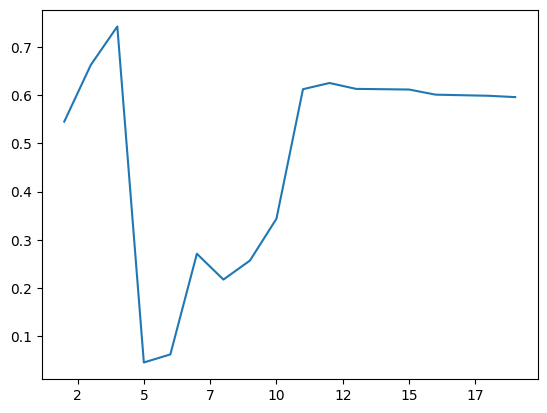

In [98]:
sns.lineplot(x=list(range(2,20)), y = ars1).xaxis.set_major_formatter(FuncFormatter(lambda x, _: int(x)))

<AxesSubplot: >

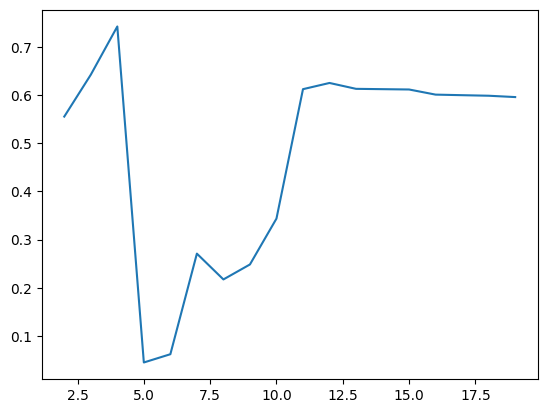

In [54]:
sns.lineplot(x=list(range(2,20)), y = ars2).xaxis.set_major_formatter(FuncFormatter(lambda x, _: int(x)))

<AxesSubplot: >

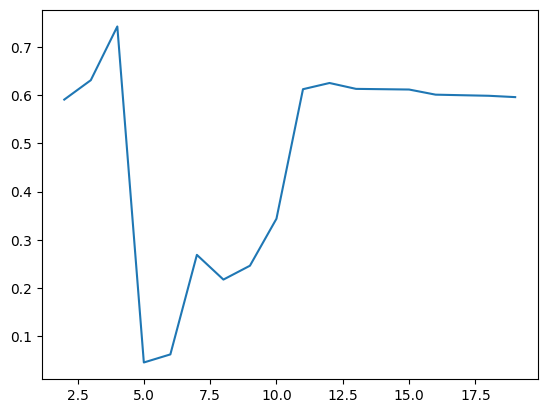

In [57]:
sns.lineplot(x=list(range(2,20)), y = ars2_2).xaxis.set_major_formatter(FuncFormatter(lambda x, _: int(x)))

<AxesSubplot: >

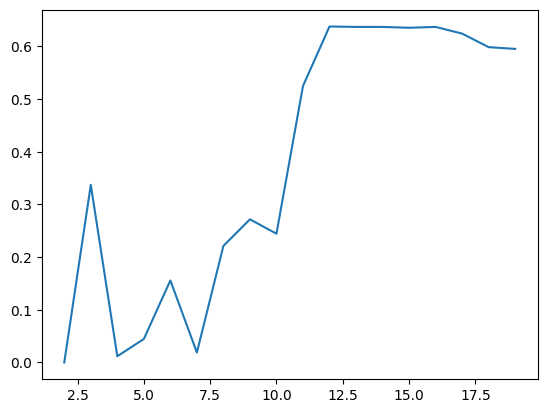

In [41]:
sns.lineplot(x=list(range(2,20)), y = ars3).xaxis.set_major_formatter(FuncFormatter(lambda x, _: int(x)))

<AxesSubplot: >

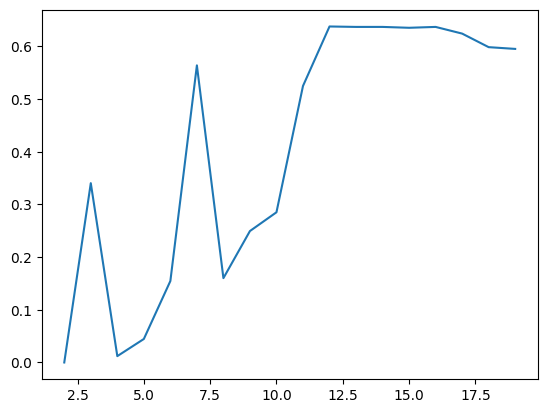

In [40]:
sns.lineplot(x=list(range(2,20)), y = ars4).xaxis.set_major_formatter(FuncFormatter(lambda x, _: int(x)))

In [74]:
def spectralClustering2Dziki(X, n_of_clusters=3, M=3, nodeRepresentationDim=3, MST=4):
    
    A, d = adjacencyMatrixUsingMnearestNeighbors2(X, M=M, M_search_thresh=MST)
    
    fw, tw = FWTFfind(d, M, MST)

    
    percs = np.linspace( 1/(float(n_of_clusters))**2 , 1/(float(n_of_clusters)), 5)
    
    for perc in percs:

        edges_to_add = defineEdgesToAdd(fw=fw,tw=tw, percentage=perc)

        A = connectTheGraph2(A, dist_indx_arr=None, fw=fw,tw=tw, edges_to_add=edges_to_add)

    L = graphLaplacian(A)
    w,v = calculateEigenVectorsOfGraphLaplacian(L)
    Z = nodeRepresentation(v,nodeRepresentationDim,n_of_components=1)

        
    kmeans = KMeans(n_clusters=n_of_clusters, random_state=0, n_init=100).fit(Z)
    
    return kmeans.labels_

In [81]:

ars2_d = []
for m in range(2,20):
    labelki = spectralClustering2Dziki(X=X, n_of_clusters=3, M=m, nodeRepresentationDim=3, MST=m+1)
    ars2_d.append(AR(labelki, labels[0]))
    
    


<AxesSubplot: >

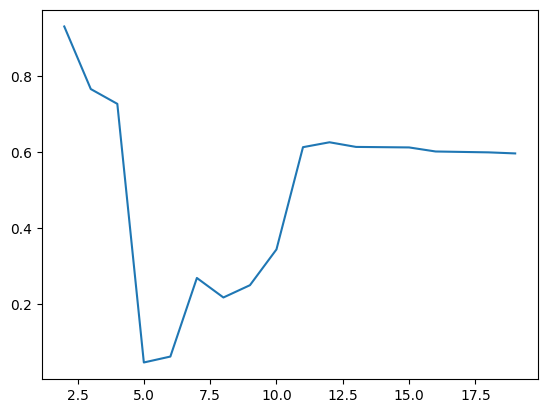

In [82]:
sns.lineplot(x=list(range(2,20)), y = ars2_d).xaxis.set_major_formatter(FuncFormatter(lambda x, _: int(x)))

In [83]:

ars2_d2 = []
for m in range(2,20):
    labelki = spectralClustering2Dziki(X=X, n_of_clusters=3, M=m, nodeRepresentationDim=3, MST=m+2)
    ars2_d2.append(AR(labelki, labels[0]))

<AxesSubplot: >

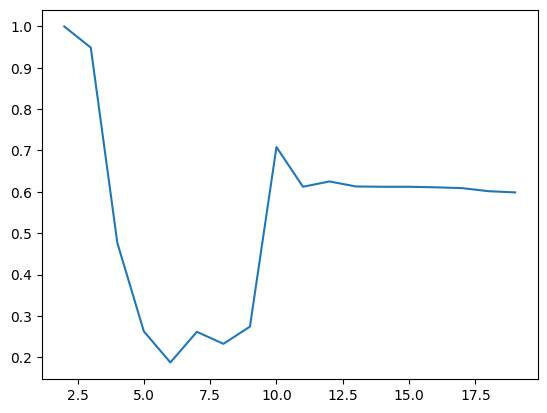

In [84]:
sns.lineplot(x=list(range(2,20)), y = ars2_d2).xaxis.set_major_formatter(FuncFormatter(lambda x, _: int(x)))

In [85]:

ars2_d3 = []
for m in range(2,20):
    labelki = spectralClustering2Dziki(X=X, n_of_clusters=3, M=m, nodeRepresentationDim=3, MST=m+3)
    ars2_d3.append(AR(labelki, labels[0]))

<AxesSubplot: >

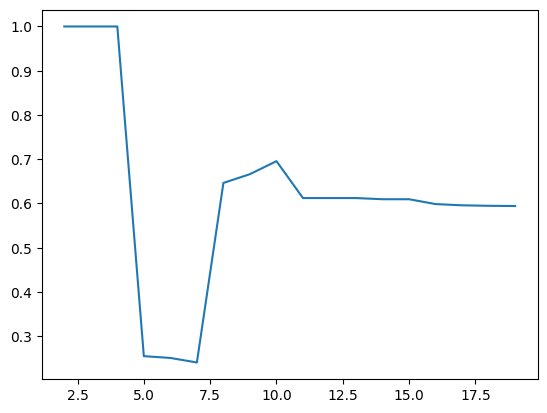

In [86]:
sns.lineplot(x=list(range(2,20)), y = ars2_d3).xaxis.set_major_formatter(FuncFormatter(lambda x, _: int(x)))

In [87]:
ars2_d4 = []
for m in range(2,20):
    labelki = spectralClustering2Dziki(X=X, n_of_clusters=3, M=m, nodeRepresentationDim=3, MST=m+4)
    ars2_d4.append(AR(labelki, labels[0]))

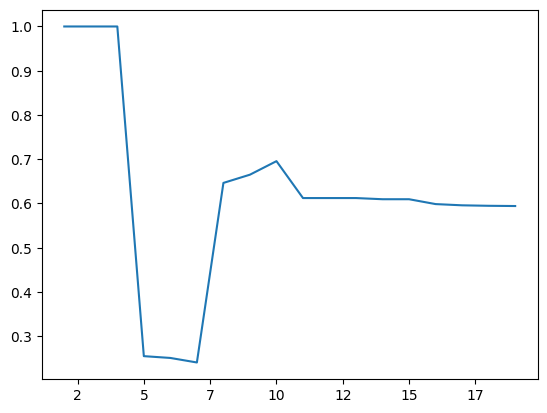

In [96]:
from  matplotlib.ticker import FuncFormatter


sns.lineplot(x=list(range(2,20)), y = ars2_d4).xaxis.set_major_formatter(FuncFormatter(lambda x, _: int(x)))

# Visualizations - one the same plot

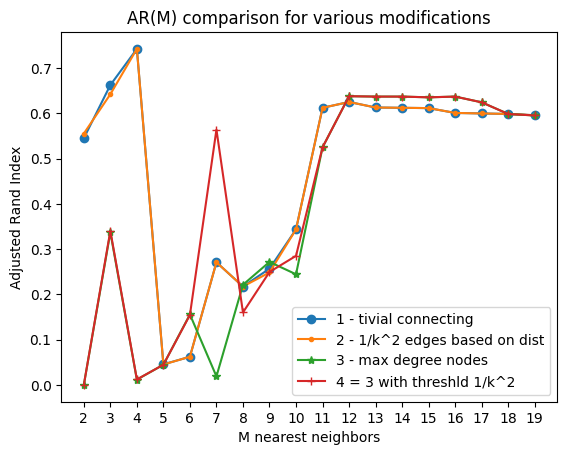

In [122]:
xs = np.array(list(range(2,20)))

fig = plt.figure()
ax = fig.add_subplot()

ax.plot(xs, np.array(ars1), marker='o')
ax.plot(xs, np.array(ars2), marker='.')
ax.plot(xs, np.array(ars3), marker='*')
ax.plot(xs, np.array(ars4), marker='+')

ax.legend( ['1 - tivial connecting', '2 - 1/k^2 edges based on dist', '3 - max degree nodes', '4 = 3 with threshld 1/k^2'])

ax.set_xlabel('M nearest neighbors')
ax.set_ylabel('Adjusted Rand Index')

ax.set_title("AR(M) comparison for various modifications")

plt.xticks(xs, (xs).astype(int))
plt.show()


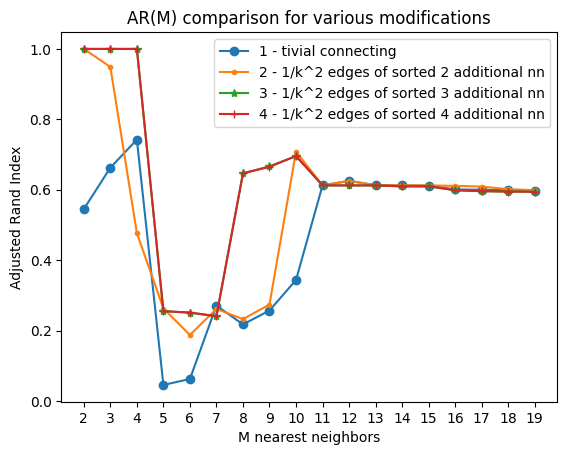

In [124]:
xs = np.array(list(range(2,20)))

fig = plt.figure()
ax = fig.add_subplot()

ax.plot(xs, np.array(ars1), marker='o')
ax.plot(xs, np.array(ars2_d2), marker='.')
ax.plot(xs, np.array(ars2_d3), marker='*')
ax.plot(xs, np.array(ars2_d4), marker='+')

ax.legend( ['1 - tivial connecting', '2 - 1/k^2 edges of sorted 2 additional nn', '3 - 1/k^2 edges of sorted 3 additional nn', '4 - 1/k^2 edges of sorted 4 additional nn'])

ax.set_xlabel('M nearest neighbors')
ax.set_ylabel('Adjusted Rand Index')

ax.set_title("AR(M) comparison for various modifications")

plt.xticks(xs, (xs).astype(int))
plt.show()


In [126]:
elapsed_time

0.0

# Time analysis

In [127]:
import time

t1 = []
for m in range(2,20):
    
    # get the start time
    st = time.time()
    labelki = spectralClustering(X=X, n_of_clusters=3, M=m, nodeRepresentationDim=3)
    # get the end time
    et = time.time()
    
    t1.append(et-st)


In [129]:
t2 = []
for m in range(2,20):
    
    # get the start time
    st = time.time()
    labelki = spectralClustering2(X=X, n_of_clusters=3, M=m, nodeRepresentationDim=3, MST=m+1)
    # get the end time
    et = time.time()
    
    t2.append(et-st)

In [130]:
t3 = []
for m in range(2,20):
    
    # get the start time
    st = time.time()
    labelki = spectralClustering3(X=X, n_of_clusters=3, M=m, nodeRepresentationDim=3)
    # get the end time
    et = time.time()
    
    t3.append(et-st)

True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True


In [131]:
t4 = []
for m in range(2,20):
    
    # get the start time
    st = time.time()
    labelki = spectralClustering4(X=X, n_of_clusters=3, M=m, nodeRepresentationDim=3)
    # get the end time
    et = time.time()
    
    t4.append(et-st)

True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True


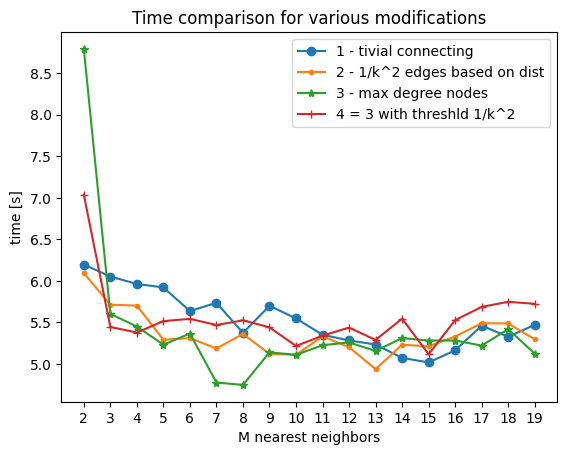

In [132]:
xs = np.array(list(range(2,20)))

fig = plt.figure()
ax = fig.add_subplot()

ax.plot(xs, np.array(t1), marker='o')
ax.plot(xs, np.array(t2), marker='.')
ax.plot(xs, np.array(t3), marker='*')
ax.plot(xs, np.array(t4), marker='+')

ax.legend( ['1 - tivial connecting', '2 - 1/k^2 edges based on dist', '3 - max degree nodes', '4 = 3 with threshld 1/k^2'])

ax.set_xlabel('M nearest neighbors')
ax.set_ylabel('time [s]')

ax.set_title("Time comparison for various modifications")

plt.xticks(xs, (xs).astype(int))
plt.show()


In [134]:
t2_d2 = []
for m in range(2,20):
    print(f'm = {m}')
    # get the start time
    st = time.time()
    labelki = spectralClustering2Dziki(X=X, n_of_clusters=3, M=m, nodeRepresentationDim=3, MST=m+2)
    # get the end time
    et = time.time()
    
    t2_d2.append(et-st)

m = 2
m = 3
m = 4
m = 5
m = 6
m = 7
m = 8
m = 9
m = 10
m = 11
m = 12
m = 13
m = 14
m = 15
m = 16
m = 17
m = 18
m = 19


In [135]:
t2_d3 = []
for m in range(2,20):
    print(f'm = {m}')
    # get the start time
    st = time.time()
    labelki = spectralClustering2Dziki(X=X, n_of_clusters=3, M=m, nodeRepresentationDim=3, MST=m+3)
    # get the end time
    et = time.time()
    
    t2_d3.append(et-st)

m = 2
m = 3
m = 4
m = 5
m = 6
m = 7
m = 8
m = 9
m = 10
m = 11
m = 12
m = 13
m = 14
m = 15
m = 16
m = 17
m = 18
m = 19


In [136]:
t2_d4 = []
for m in range(2,20):
    print(f'm = {m}')
    # get the start time
    st = time.time()
    labelki = spectralClustering2Dziki(X=X, n_of_clusters=3, M=m, nodeRepresentationDim=3, MST=m+4)
    # get the end time
    et = time.time()
    
    t2_d4.append(et-st)

m = 2
m = 3
m = 4
m = 5
m = 6
m = 7
m = 8
m = 9
m = 10
m = 11
m = 12
m = 13
m = 14
m = 15
m = 16
m = 17
m = 18
m = 19


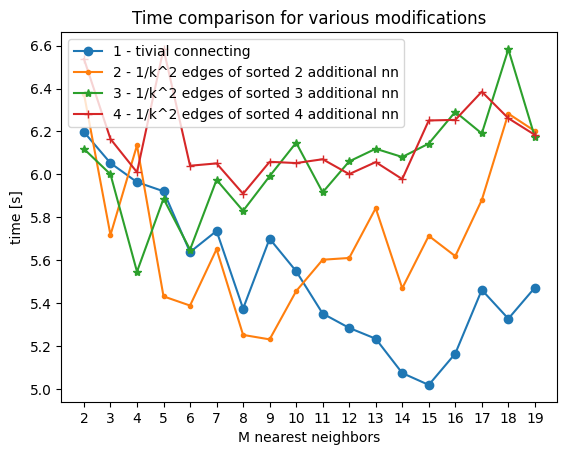

In [137]:
xs = np.array(list(range(2,20)))

fig = plt.figure()
ax = fig.add_subplot()

ax.plot(xs, np.array(t1), marker='o')
ax.plot(xs, np.array(t2_d2), marker='.')
ax.plot(xs, np.array(t2_d3), marker='*')
ax.plot(xs, np.array(t2_d4), marker='+')

ax.legend( ['1 - tivial connecting', '2 - 1/k^2 edges of sorted 2 additional nn', '3 - 1/k^2 edges of sorted 3 additional nn', '4 - 1/k^2 edges of sorted 4 additional nn'])

ax.set_xlabel('M nearest neighbors')
ax.set_ylabel('time [s]')

ax.set_title("Time comparison for various modifications")

plt.xticks(xs, (xs).astype(int))
plt.show()
